# Script for Running OP

In [2]:
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
from IPython.display import HTML

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [3]:
clat = [49.195045]
clon = [-123.301956]
cz = 60

In [4]:
n_day = int(2) # amount of particles released 
#
release_time = datetime.datetime(2022,1,1) # set the hourly release times
#

In [5]:
lat = [clat] * n_day
lon = [clon] * n_day
z = [cz] * n_day # this repeats the same depth twice
time = [release_time] * 2

Just the OP advection Kernel is added for faster runs. But you can add any other Kernel if you want

Function to run OP

In [ ]:
def simulation_run(start_time, sim_length, n_day):
    #
    #
    #### DATA AND OUTPUT PATHS ####
    path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
    'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
    'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
    'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
    'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2',
    'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
    'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
    #
    coords = xr.open_dataset(path['coords'], decode_times=False)
    mask = xr.open_dataset(path['mask'])
    #### Function for getting dates stamps ####
    def get_timestamps(start_time,sim_length):
        timestamps=[]
        duration = timedelta(days=sim_length)
        for day in range(duration.days):
            timestamps.append([start_time + timedelta(days=day)])
        return np.array(timestamps, dtype='datetime64')
    #
    #### Function to get grid point gridX and gridY ####
    path_NEMO = make_prefix(start_time,path['NEMO'])
    jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
    def finder(lati,loni):
        j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
        i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
        return j,i
    #
    #### Setting deploying cordinates ####
    #
    # COORDINATES
     # set up the coordinates that you want 
    clat = [49.195045]
    clon = [-123.501956]
    z1 = 10
    z2 = 70
    #
    release_time = start_time
    #
    #
    lat = [clat] * n_day
    lon = [clon] * n_day
    depth = [z1, z2]  # two different depths (lenghts with the lon, lat and time variables must match)
    time = [release_time] * n_day
    #
    a, b = finder(clat[0], clon[0])
    print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
    #
    duration = timedelta(days=sim_length) # RUN DURATION IN DAYS
    #
    #
    #### Name of the output file #### 
    name_states = 'OP_run_for_'+str(sim_length)+'_days_'+str(n_day)+'_per_day_'
    daterange = [start_time+timedelta(days=i) for i in range(sim_length)]
    fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start_time, start_time+duration]) + '.zarr'
    outfile_states = os.path.join(path['out'], fn)
    #
    local = 0
    ####
    ####
    ####
    #### CREATING FIELDSETS ####
    varlist=['U','V','W']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
    field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')
    #
    varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol','last_cell_index']
    filenames,variables=filename_set(start_time,sim_length,varlist)
    #Add SSH 
    dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
    SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
    field_set.add_field(SSH)
    #
    ####
    #### DEFINE A PARTICLE TYPE AND SET ####
    class MPParticle(JITParticle):    
        n = Variable('n', initial = n_day)

    # Here you will be saying to the particles where and when to start
    pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat,
    depth=depth, time=time)
    ####
#
    def CheckOutOfBounds(particle, fieldset, time):
        if particle.state == StatusCode.ErrorOutOfBounds:    
            particle.delete()
    #        
    def KeepInOcean(particle, fieldset, time):
        if particle.state == StatusCode.ErrorThroughSurface:
            particle.depth = 0.0
            particle.state = StatusCode.Success             
    ##########################################################
    #
    #
    runtime = duration  # Total simulation runtime
    dt = 5     # Simulation timestep in seconds
    output_interval = timedelta(hours=1)
    output_file = pset_states.ParticleFile(name=outfile_states, outputdt=output_interval)
    kernels = [AdvectionRK4, CheckOutOfBounds, KeepInOcean]
    #
    #
    pset_states.execute(kernels,
            runtime=runtime,
            dt=dt,
            output_file=output_file)

    #
    return outfile_states

In [7]:
test_run = simulation_run(datetime.datetime(2023,1,1), 6, 2)

The total depth at this location is 337.25 m


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:648: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:648: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:648: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(
/

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/OP_run_for_6_days_2_per_day_20230101_1n_20230107_1n.zarr.
100%|██████████| 518400.0/518400.0 [05:09<00:00, 1674.46it/s]


In [4]:
filename = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/OP_run_for_6_days_2_per_day_20230101_1n_20230107_1n.zarr'

In [5]:
data = xr.open_dataset(filename)

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


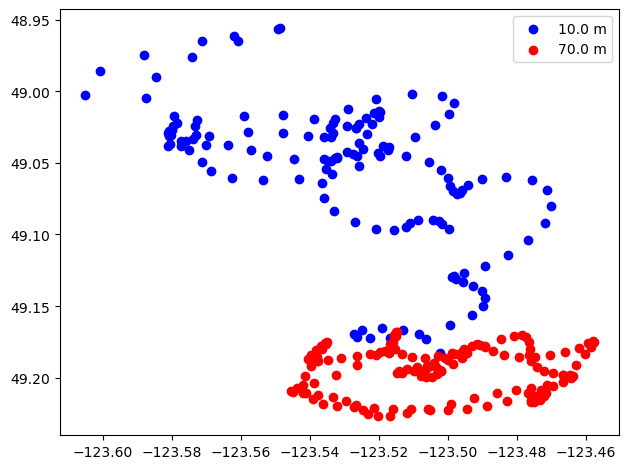

In [13]:
plt.scatter(data.lon[0,:], data.lat[0,:], c = 'b', label = str(data.z[0,0].values) + ' m')
plt.scatter(data.lon[1,:], data.lat[1,:], c = 'r', label = str(data.z[1,0].values) + ' m')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()